In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

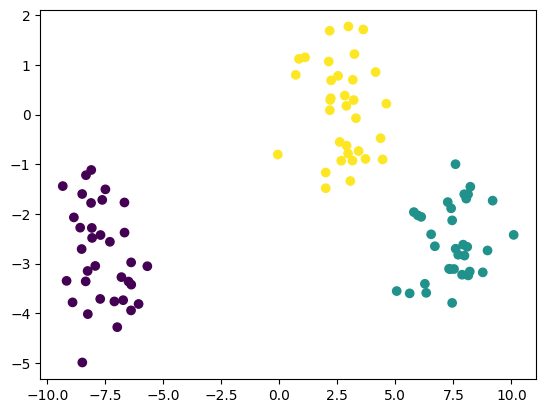

In [156]:
X,y = make_blobs()
plt.scatter(X[:,0], X[:,1],c=y);

## K-Means Clustering Algorithm

#### 1. Initialization
Randomly select k initial centroids from your dataset. These centroids will serve as the starting points for your clusters. The random selection ensures that the algorithm explores different starting positions, which can lead to better clustering results.

In [157]:
def init_centroids(X: np.array, k: int) -> np.array:
    "Randomly select k points which will represent the k centroids."
    indices = np.random.choice(X.shape[0],size=k,replace=False)
    return X[indices]

k = 3
C = init_centroids(X,k)

#### 2. Assignment
For each data point, you need to calculate the distance to each centroid. Typically, the Euclidean distance is used, but other distance metrics can also be applied.<br>
Once you have the distances, assign the data point to the cluster of the nearest centroid. This step ensures that each point is grouped with the closest centroid, forming clusters around these centroids.

In [158]:
# compute euclidean distances 
distances = np.linalg.norm(X[:,None]-C,axis=2)

nearest_c = np.argmin(distances,axis=1)

#### 3. Update
After assigning all the data points, update each centroid to be the mean of the points assigned to it. This means you calculate the average position of all points in a cluster and move the centroid to this new position. This step refines the cluster centers.

In [159]:
old_centroids = np.copy(C)

# if no points for 1 centroid, keep centroid the same as before
centroids = np.array([
    np.mean(X[nearest_c==i],axis=0)if len(X[nearest_c==i])>0 else C[i]
    for i in range(len(C))
])

#### 4. Iteration
Repeat the assignment and update steps. In each iteration, the centroids move based on the mean positions of the points in their clusters, and points are reassigned to the nearest centroid.<br>
The algorithm iterates until the centroids no longer move significantly between iterations. This indicates that the clusters have stabilized and the algorithm has converged.

In [160]:
def k_means(X,k,max_iter,n_init=1):

    min_dist = np.inf
    best_clustering = None

    for _ in range(n_init):

        for _ in range(max_iter):
            # initialize centroids
            C = init_centroids(X,k)

            # compute current distances
            distances = np.linalg.norm(X[:,None]-C,axis=2)
            
            # assign each point to nearest cluster & compute total dist
            nearest_c = np.argmin(distances,axis=1)
            total_dist = np.sum(np.min(distances,axis=1))

            old_C = np.copy(C)

            # update centroids
            C = np.array([
                np.mean(X[nearest_c==i],axis=0)if len(X[nearest_c==i])>0 else C[i]
                for i in range(len(C))
            ])
            
            if np.linalg.norm(C-old_C) < pow(10,-8):
                break

        if total_dist < min_dist:
            min_dist = total_dist
            best_clustering = nearest_c

    return best_clustering

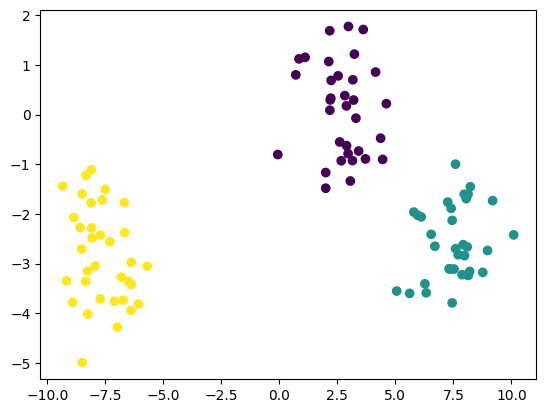

In [161]:
cluster_assignments = k_means(X,k=3,max_iter=100,n_init=10)
plt.scatter(X[:,0],X[:,1],c=cluster_assignments);

FCM

In [162]:
D = np.array([
    [1,2,3],
    [4,5,6]
])

D1 = D[:,None,:]

D2 = D[None,:,:]

D1/D2

array([[[1.  , 1.  , 1.  ],
        [0.25, 0.4 , 0.5 ]],

       [[4.  , 2.5 , 2.  ],
        [1.  , 1.  , 1.  ]]])

In [163]:
# 2,1,3 / 1,2,3 -> 2,2,3

In [164]:
D/D

array([[1., 1., 1.],
       [1., 1., 1.]])

## Fuzzy C-Means Clustering Algorithm

In [165]:
import numpy as np
import matplotlib.pyplot as plt

Example data

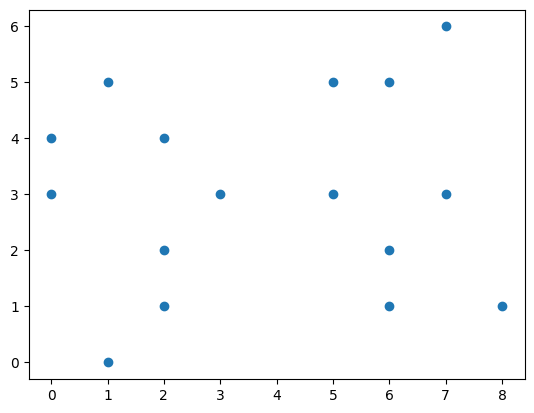

In [166]:
Y = np.array([
    [0, 4],
    [0, 3],
    [1, 5],
    [2, 4],
    [3, 3],
    [2, 2],
    [2, 1],
    [1, 0],
    [5, 5],
    [6, 5],
    [7, 6],
    [5, 3],
    [7, 3],
    [6, 2],
    [6, 1],
    [8, 1]
    ])
plt.scatter(Y[:,0], Y[:,1]);

(A1) Fix $c$, $m$, $A$, $||k||_A$. Choose an initial matrix $U^{(o)} \in M_{fc}$. Then at step $k, k, = 0, 1, . . . ,
LMAX$.

In [167]:
c = 2 # nr clusters
N = len(Y) # nr data points
m = 2
A = ...

(A2) Compute means $\hat{v}^{(k)}$, $i = 1, 2, . . . , c$ with equation (11a):
$$  \hat{v}_i = \sum_{k=1}^N (\hat{u}_{ik})^m y_k \Big/ \sum_{k=1}^N  (\hat{u}_{ik})^m $$

In [168]:
def get_cluster_centers_slow(U,N,c,Y,m=2):

    weighted_sums = np.array([
            sum(
                U[i,k]**m * Y[k]
                for k in range(N) # for each point
            )
            for i in range(c) # for each cluster id
        ])
    
    mem_sums = np.array([
            sum(
                U[i,k]**m
                for k in range(N) # for each point
            )
            for i in range(c) # for each cluster id
        ])
    
    return weighted_sums / mem_sums


# c x N matrix where each column k represents a data point
# each element U_ik is the membership degree of point k to cluster i
# each column k must sum to 1
def init_U0(c,N,rndm=True):
    
    if rndm:
        U = np.random.rand(c,N)
        return U / np.sum(U,axis=0,keepdims=True)
    else:
        raise NotImplementedError("confusion in the original paper about this method")

U0 = init_U0(c,N)

get_cluster_centers_slow(U0,N,c,Y,m)

array([[4.587, 3.393],
       [2.744, 2.823]])

More efficient:

In [169]:
def get_cluster_centers(U,N,c,Y,m=2):

    Um = U ** m
    numerator = Um @ Y # (c x N) @ (N x d) => (c x d)
    denominator = Um.sum(axis=1, keepdims=True)
    
    return numerator / denominator

U0 = init_U0(c,N)

get_cluster_centers(U0,N,c,Y,m)

array([[4.554, 2.723],
       [2.633, 3.333]])

(A3) Compute an updated membership matrix $\hat{U}^{(k+1)} = [\hat{u}_{ik}^{(k+1)}]$ with equation (11b):
$$  \hat{u}_{ik} = \left(\sum_{j=1}^c \left(\frac{\hat{d}_{ik}}{\hat{d}_{jk}}\right)^{2/(m-1)} \right)^{-1}  $$

In [170]:
def update_U(Y,V,m=2,dist_measure="euclidean",A=None):

    # get squared distances
    d2 = a_norm_distances(Y=Y,V=V,mode=dist_measure,A=A)
    d2 = np.fmax(d2,1e-10) # avoid division by zero
    
    exponent = 1.0 / (m-1) # use 1.0 instead of 2.0 bc distances are squared
    # get distance ratios
    ratio = (d2[:,None,:] / d2[None,:,:]) ** exponent
    # sum and take inverse to get memberships
    return 1.0 / np.sum(ratio, axis=0)

def a_norm_distances(Y,V,mode="euclidean",A=None):

    if A is None:
        if mode == "euclidean":
            A = np.eye(Y.shape[1])
        elif mode == "diagonal":
            A = np.diag(1 / np.var(Y, axis=0))
        elif mode == "mahalanobis":
            A = np.linalg.inv(np.cov(Y, rowvar=False))
        else:
            raise ValueError(f"Unknown mode: '{mode}'")
    
    # N.shape: (N,d) - V.shape: (c,d) -> matrix of differences (c,N,d)
    diff = Y[None,:,:] - V[:,None,:] # vector diffs y_k - v_i
    # (c,N,d) @ (d,d) @ (c,N,d) -> (c,N)
    return np.einsum("cnd,df,cnf->cn",diff, A, diff) 


In [171]:
# intuition behind code in update_U

D = np.array([
    [1.0, 2.0, 3.0],   # distances from cluster 0
    [4.0, 5.0, 6.0]    # distances from cluster 1
])  # shape (2, 3)

D1 = D[:, None, :]   # shape (2, 1, 3)
D2 = D[None, :, :]   # shape (1, 2, 3)

D1 / D2   # shape (2, 2, 3)


array([[[1.  , 1.  , 1.  ],
        [0.25, 0.4 , 0.5 ]],

       [[4.  , 2.5 , 2.  ],
        [1.  , 1.  , 1.  ]]])

(A4) Compare $\hat{U}_{ik}^{k+1}$ to $\hat{U}_{ik}^{k}$ in any convenient matrix norm. If $||\hat{U}_{ik}^{k+1}-\hat{U}_{ik}^{k}|| < \epsilon$ stop. Otherwise, set $\hat{U}_{ik}^{k} = \hat{U}_{ik}^{k+1}$ and return to (A2).

In [172]:
epsilon = 1e-5
V = get_cluster_centers(U0,N,c,Y,m)
U1 = update_U(Y,V,m=2,dist_measure="euclidean")

if np.max(a_norm_distances(U0,U1)) < epsilon:
    print("converged")

#### Full Picard iteration


In [173]:
c = 2
m = 2
distance_measure = "euclidean"
max_iter = 100

# init U0
U = init_U0(c,N)

# iterate until convergence or max_iter
for _ in range(max_iter):
    # compute cluster centers
    V = get_cluster_centers(U,N,c,Y,m)

    # update memberships
    U_new = update_U(Y,V,m=m,dist_measure=distance_measure)

    # check convergence
    if np.max(abs(U - U_new)) < epsilon:
        print("converged")
        break
    else:
        U = U_new


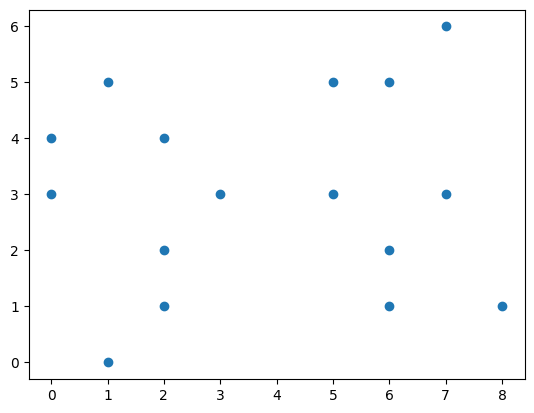

In [174]:
Y = np.array([
    [0, 4],
    [0, 3],
    [1, 5],
    [2, 4],
    [3, 3],
    [2, 2],
    [2, 1],
    [1, 0],
    [5, 5],
    [6, 5],
    [7, 6],
    [5, 3],
    [7, 3],
    [6, 2],
    [6, 1],
    [8, 1]
    ])
plt.scatter(Y[:,0], Y[:,1]);

(A1) Fix $c$, $m$, $A$, $||k||_A$. Choose an initial matrix $U^{(o)} \in M_{fc}$. Then at step $k, k, = 0, 1, . . . ,
LMAX$.

In [175]:
c = 2 # nr clusters
N = len(Y) # nr data points
m = 2
A = ...

(A2) Compute means $\hat{v}^{(k)}$, $i = 1, 2, . . . , c$ with equation (11a):
$$  \hat{v}_i = \sum_{k=1}^N (\hat{u}_{ik})^m y_k \Big/ \sum_{k=1}^N  (\hat{u}_{ik})^m $$

In [176]:
def get_cluster_centers_slow(U,N,c,Y,m=2):

    weighted_sums = np.array([
            sum(
                U[i,k]**m * Y[k]
                for k in range(N) # for each point
            )
            for i in range(c) # for each cluster id
        ])
    
    mem_sums = np.array([
            sum(
                U[i,k]**m
                for k in range(N) # for each point
            )
            for i in range(c) # for each cluster id
        ])
    
    return weighted_sums / mem_sums


# c x N matrix where each column k represents a data point
# each element U_ik is the membership degree of point k to cluster i
# each column k must sum to 1
def init_U0(c,N,rndm=True):
    
    if rndm:
        U = np.random.rand(c,N)
        return U / np.sum(U,axis=0,keepdims=True)
    else:
        raise NotImplementedError("confusion in the original paper about this method")

U0 = init_U0(c,N)

get_cluster_centers_slow(U0,N,c,Y,m)

array([[3.498, 3.14 ],
       [4.094, 3.056]])

More efficient:

In [177]:
def get_cluster_centers(U,N,c,Y,m=2):

    Um = U ** m
    numerator = Um @ Y # (c x N) @ (N x d) => (c x d)
    denominator = Um.sum(axis=1, keepdims=True)
    
    return numerator / denominator

U0 = init_U0(c,N)

get_cluster_centers(U0,N,c,Y,m)

array([[4.181, 3.203],
       [3.46 , 2.758]])

(A3) Compute an updated membership matrix $\hat{U}^{(k+1)} = [\hat{u}_{ik}^{(k+1)}]$ with equation (11b):
$$  \hat{u}_{ik} = \left(\sum_{j=1}^c \left(\frac{\hat{d}_{ik}}{\hat{d}_{jk}}\right)^{2/(m-1)} \right)^{-1}  $$

In [178]:
def update_U(Y,V,m=2,dist_measure="euclidean",A=None):

    # get squared distances
    d2 = a_norm_distances(Y=Y,V=V,mode=dist_measure,A=A)
    d2 = np.fmax(d2,1e-10) # avoid division by zero
    
    exponent = 1.0 / (m-1) # use 1.0 instead of 2.0 bc distances are squared
    # get distance ratios
    ratio = (d2[:,None,:] / d2[None,:,:]) ** exponent
    # sum and take inverse to get memberships
    return 1.0 / np.sum(ratio, axis=0)

def a_norm_distances(Y,V,mode="euclidean",A=None):

    if A is None:
        if mode == "euclidean":
            A = np.eye(Y.shape[1])
        elif mode == "diagonal":
            A = np.diag(1 / np.var(Y, axis=0))
        elif mode == "mahalanobis":
            A = np.linalg.inv(np.cov(Y, rowvar=False))
        else:
            raise ValueError(f"Unknown mode: '{mode}'")
    
    # N.shape: (N,d) - V.shape: (c,d) -> matrix of differences (c,N,d)
    diff = Y[None,:,:] - V[:,None,:] # vector diffs y_k - v_i
    # (c,N,d) @ (d,d) @ (c,N,d) -> (c,N)
    return np.einsum("cnd,df,cnf->cn",diff, A, diff) 


In [179]:
# intuition behind code in update_U

D = np.array([
    [1.0, 2.0, 3.0],   # distances from cluster 0
    [4.0, 5.0, 6.0]    # distances from cluster 1
])  # shape (2, 3)

D1 = D[:, None, :]   # shape (2, 1, 3)
D2 = D[None, :, :]   # shape (1, 2, 3)

D1 / D2   # shape (2, 2, 3)


array([[[1.  , 1.  , 1.  ],
        [0.25, 0.4 , 0.5 ]],

       [[4.  , 2.5 , 2.  ],
        [1.  , 1.  , 1.  ]]])

(A4) Compare $\hat{U}_{ik}^{k+1}$ to $\hat{U}_{ik}^{k}$ in any convenient matrix norm. If $||\hat{U}_{ik}^{k+1}-\hat{U}_{ik}^{k}|| < \epsilon$ stop. Otherwise, set $\hat{U}_{ik}^{k} = \hat{U}_{ik}^{k+1}$ and return to (A2).

In [180]:
epsilon = 1e-5
V = get_cluster_centers(U0,N,c,Y,m)
U1 = update_U(Y,V,m=2,dist_measure="euclidean")

if np.max(a_norm_distances(U0,U1)) < epsilon:
    print("converged")

#### Full Picard iteration


In [181]:
c = 2
m = 2
distance_measure = "euclidean"
max_iter = 100

# init U0
U = init_U0(c,N)

# iterate until convergence or max_iter
for _ in range(max_iter):
    # compute cluster centers
    V = get_cluster_centers(U,N,c,Y,m)

    # update memberships
    U_new = update_U(Y,V,m=m,dist_measure=distance_measure)

    # check convergence
    if np.max(abs(U - U_new)) < epsilon:
        print("converged")
        break
    else:
        U = U_new

Epic visualizaaaations

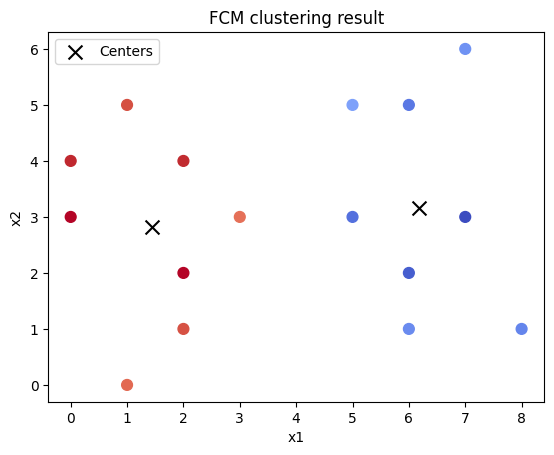

In [182]:
V = get_cluster_centers(U, N, c, Y)
plt.scatter(Y[:, 0], Y[:, 1], c=U[0], cmap='coolwarm', s=60)
plt.scatter(V[:, 0], V[:, 1], marker='x', c='black', s=100, label='Centers')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("FCM clustering result")
plt.show()

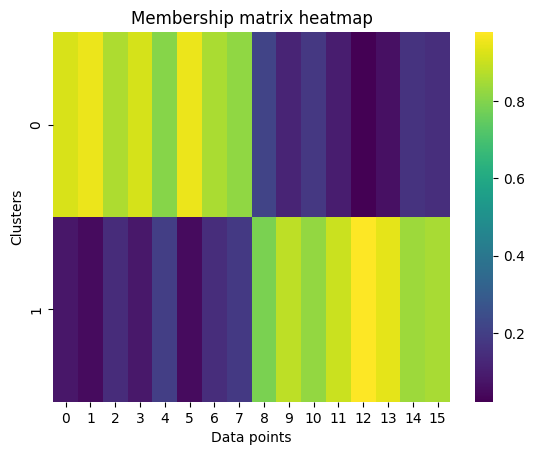

In [183]:
import seaborn as sns
sns.heatmap(U, annot=False, cmap="viridis")
plt.xlabel("Data points")
plt.ylabel("Clusters")
plt.title("Membership matrix heatmap")
plt.show()


## Possibilistic C-Means Clustering Algorithm

In [184]:
import sys
sys.path.insert(0,"/home/wouterf/Documents/projects/Clustering/algorithms")

from fuzzy_c_means import FCM

initialize parameters

In [185]:
nr_clusters = ...
m = 2 # fuzzifier
iteration_counter = 1

Initialize possibilistic c-partition $\mathbf{U}^{(o)}$

In [186]:
# e.g. using FCM
FCM_clustering = FCM(c=c,m=m)
U = FCM_clustering.fit_predict(X)
V = FCM_clustering.V_

Estimate $\eta_k$ using
$$ \eta_k = R \frac{\sum_{i=1}^N u_{ik}^m d^2_{ik}}{\sum_{i=1}^N u_{ik}^m} $$

In [187]:
def get_eta(U,V,X,m=2,R=1):
    
    Um = U ** m
    
    D2 = a_norm_distances(X,V)

    numerator = np.sum(
        np.multiply(Um,D2),
        axis=1)

    denominator = Um.sum(axis=1)
    
    
    return R * numerator / denominator


def a_norm_distances(X,V,A=None,distance_measure="euclidean"):

    if A is None:
        if distance_measure == "euclidean":
            A = np.eye(X.shape[1])
        elif distance_measure == "diagonal":
            A = np.diag(1 / np.var(X, axis=0))
        elif distance_measure == "mahalanobis":
            A = np.linalg.inv(np.cov(X, rowvar=False))
        else:
            raise ValueError(f"Unknown distance measure: '{distance_measure}'")
    
    # N.shape: (N,d) - V.shape: (c,d) -> matrix of differences (c,N,d)
    diff = X[None,:,:] - V[:,None,:] # vector diffs y_k - v_i
    # (c,N,d) @ (d,d) @ (c,N,d) -> (c,N)
    return np.einsum("cnd,df,cnf->cn",diff, A, diff)

eta = get_eta(U,V,X)

Update prototypes using
$$ \mathbf{c}_k = \frac{\sum_{i=1}^N u_{ik}^m \mathbf{x}_i}{\sum_{i=1}^N u_{ik}^m} $$

In [188]:
def update_V(U,X,m=2):

    Um = U ** m

    numerator = Um @ X

    denominator = Um.sum(axis=1,keepdims=True)

    return numerator / denominator

V = update_V(U,X)
V

array([[-7.522, -2.792],
       [ 5.287, -1.326]])

Update memberships using 
$$ u_{ik} = \frac{1}{1+\left( \frac{d_{ik}^2}{\eta_k} \right)^{\frac{1}{m-1}}} $$

In [189]:
def update_U(eta,V,X,m=2):

    D2 = a_norm_distances(X,V)

    denominator = 1 + (D2 / eta[:,None]) ** (1/(m-1))

    return 1 / denominator

U_new = update_U(eta,V,X)
U_new.shape

(2, 100)

Check convergence

In [190]:
# check convergence
if np.max(abs(U - U_new)) < epsilon:
    print("converged")
    # break
else:
    U = U_new

Iterative procedure

In [191]:
# init params
nr_clusters = 3
m = 2 # fuzzifier
max_iter = 100

# init U and V using FCM 
FCM_clustering = FCM(c=nr_clusters,m=m)
U = FCM_clustering.fit_predict(X)
V = FCM_clustering.V_

# estimate eta_k's
eta = get_eta(U,V,X)

for _ in range(max_iter):
    # update cluster prototypes
    V = update_V(U,X)

    # compute new memberships
    U_new = update_U(eta,V,X)

    # check convergence
    if np.max(abs(U - U_new)) < epsilon:
        print("converged")
        break
    else:
        U = U_new

U_ = U
V_ = update_V(U_,X)

converged


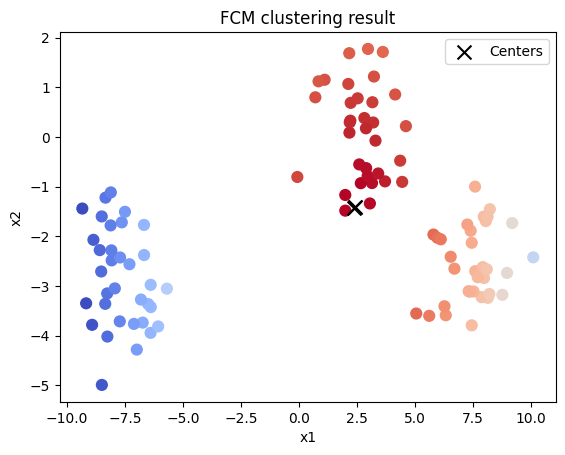

In [192]:
plt.scatter(X[:, 0], X[:, 1], c=U_[0], cmap='coolwarm', s=60)
plt.scatter(V_[:, 0], V_[:, 1], marker='x', c='black', s=100, label='Centers')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("FCM clustering result")
plt.show()

In [193]:
X = np.array([
    # Cluster 1 ~ (0,0)
    [-0.30,  0.20], [-0.20, -0.10], [ 0.10,  0.00], [ 0.20,  0.30], [-0.10,  0.20],
    [ 0.30, -0.20], [ 0.00, -0.30], [ 0.25,  0.10], [-0.25, -0.15], [ 0.05,  0.15],
    [-0.15,  0.05], [ 0.10, -0.25], [-0.05, -0.10], [ 0.20, -0.05], [-0.20,  0.00],

    # Cluster 2 ~ (5,0)
    [ 4.70,  0.20], [ 4.80, -0.10], [ 5.10,  0.00], [ 5.20,  0.30], [ 4.90,  0.20],
    [ 5.30, -0.20], [ 5.00, -0.30], [ 5.25,  0.10], [ 4.75, -0.15], [ 5.05,  0.15],
    [ 4.85,  0.05], [ 5.10, -0.25], [ 4.95, -0.10], [ 5.20, -0.05], [ 4.80,  0.00],

    # Cluster 3 ~ (0,5)
    [-0.30,  5.20], [-0.20,  4.90], [ 0.10,  5.00], [ 0.20,  5.30], [-0.10,  5.20],
    [ 0.30,  4.80], [ 0.00,  4.70], [ 0.25,  5.10], [-0.25,  4.85], [ 0.05,  5.15],
    [-0.15,  5.05], [ 0.10,  4.75], [-0.05,  4.90], [ 0.20,  4.95], [-0.20,  5.00],
], dtype=float)

In [194]:
# init params
nr_clusters = 3
m = 2 # fuzzifier
max_iter = 100

# init U and V using FCM 
FCM_clustering = FCM(c=nr_clusters,m=m)
U = FCM_clustering.fit_predict(X)
V = FCM_clustering.V_

# estimate eta_k's
eta = get_eta(U,V,X)

for _ in range(max_iter):
    # update cluster prototypes
    V = update_V(U,X)

    # compute new memberships
    U_new = update_U(eta,V,X)

    # check convergence
    if np.max(abs(U - U_new)) < epsilon:
        print("converged")
        break
    else:
        U = U_new

U_ = U
V_ = update_V(U_,X)

converged


color by argmax

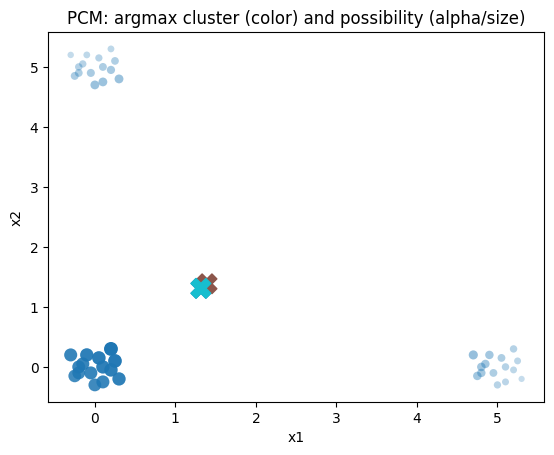

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs: X (N,2), V (c,2), U (c,N)
N = X.shape[0]
labels = np.argmax(U, axis=0)                              # length N
strength = U[labels, np.arange(N)]                         # length N
# normalize to [0,1] for alpha/size (avoid divide-by-zero)
smin, smax = strength.min(), strength.max()
norm = (strength - smin) / (smax - smin + 1e-12)

plt.figure()
scatter = plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10',
                      alpha=0.25 + 0.75*norm, s=20 + 80*norm, edgecolors='none')
plt.scatter(V[:,0], V[:,1], marker='X', s=200, c=np.arange(V.shape[0]), cmap='tab10')
plt.title("PCM: argmax cluster (color) and possibility (alpha/size)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.show()


1 Plot per cluster

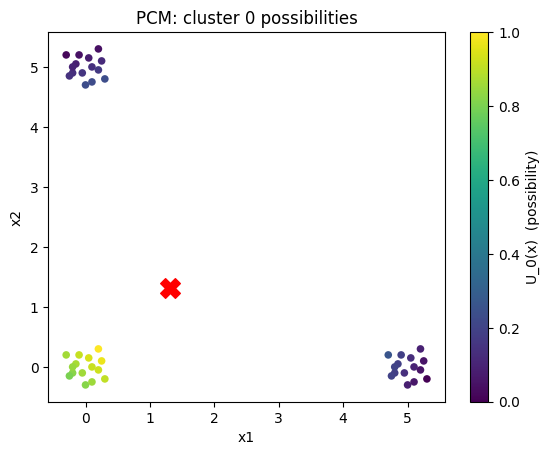

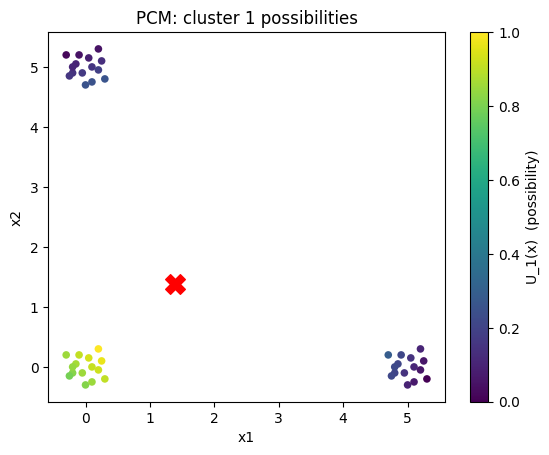

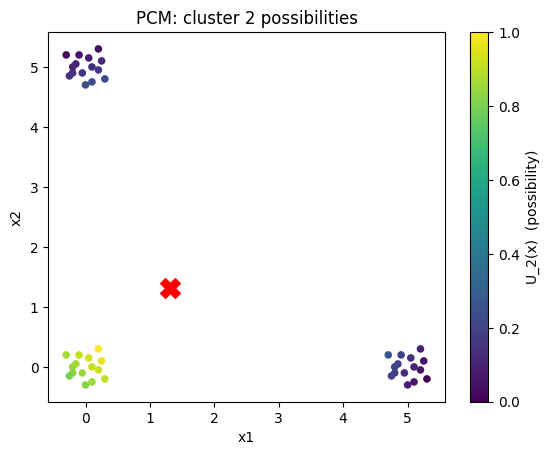

In [197]:
import matplotlib.pyplot as plt

c = U.shape[0]
for k in range(c):
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=U[k], cmap='viridis', s=30, edgecolors='none')
    plt.scatter(V[k,0], V[k,1], marker='X', s=200, color='red')
    plt.colorbar(label=f"U_{k}(x)  (possibility)")
    plt.title(f"PCM: cluster {k} possibilities")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.show()


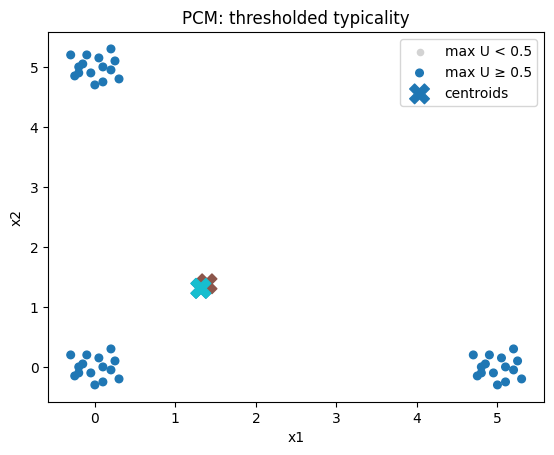

In [198]:
tau = 0.5  # user-chosen threshold
mask = U.max(axis=0) >= tau
plt.figure()
plt.scatter(X[~mask,0], X[~mask,1], c='lightgray', s=20, label=f"max U < {tau}")
plt.scatter(X[mask,0], X[mask,1], c=np.argmax(U[:,mask], axis=0), cmap='tab10', s=30, label=f"max U ≥ {tau}")
plt.scatter(V[:,0], V[:,1], marker='X', s=200, c=np.arange(V.shape[0]), cmap='tab10', label='centroids')
plt.legend(); plt.xlabel("x1"); plt.ylabel("x2"); plt.title("PCM: thresholded typicality"); plt.show()
